# **Import Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Setting**

In [2]:
from sklearn.isotonic import isotonic_regression
import cvxpy as cp
import numpy as np
import csv, os
from scipy import stats
from sklearn import metrics
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import statistics
from scipy.stats import levene
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

!apt-get install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

# Set the text properties to use LaTeX fonts with Computer Modern
plt.rcParams.update({
    'text.usetex': True,  # Use LaTeX for rendering text
    'font.family': 'serif',  # Use a serif font family (which will be Computer Modern)
    'font.serif': ['Computer Modern Roman'],  # Explicitly use the Computer Modern font
    'axes.unicode_minus': False,  # Ensure minus signs are displayed correctly
    'font.size': 42,  #In a row, use 20 for single picture, # 30 for double figures, # 55 for four figures
    'figure.figsize': (10,20),  # Figure size in inches
    'figure.dpi': 300,  # Dots per inch (high resolution)
})

def format_func(value, tick_number):
    if value < 10:
        return f"{value:.2f}"
    elif value < 100:
        return f"{value:.1f}"
    else:
        return f"{int(value)}"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0
  libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb
  poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils tex-common
  tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-framework-java l

# **Function: Partition all submissions according to "Greedy" and "Multi-owner" methods**


In [3]:
def validate(partition, graph, n):
	# check that
	# 1. each paper is in exactly one partition
	# 2. the number of papers in all partition is equal to the number of papers
	# 3. each partition has at least two authors owns all papers in the partition

	papers = set()
	full_author_parts = []
	for part in partition[:-1]:
		assert( len(part.intersection(papers)) == 0 )
		papers |= part
		# find all authors that can rank all papers in this part
		cnt = 0
		author_part = set()
		for author, val in graph.items():
			if len(val.intersection(part)) == len(part):
				cnt += 1
				author_part.add(author)

		# assert( cnt >= 2 )
		full_author_parts.append(author_part)

	# add the last partition
	full_author_parts.append(set())
	papers |= partition[-1]
	assert(len(papers) == n)

	return full_author_parts


def greedy(graph, m, n, randomize=False, level=1):
	partition = []
	author_parts = []
	allocated_papers = set()


	if level == 1:
		parts = [ graph[i].copy() for i in range(m) ]
		index2pair = [ set([i]) for i in range(m) ]
	elif level == 2:
		parts = [ graph[i].intersection(graph[j])  for i in range(m) for j in range(i+1, m) ]
		index2pair = [ set([i,j]) for i in range(m) for j in range(i+1, m) ]

	max_idx = 0
	max_val = 0
	active_indices = set( [i for i in range(len(parts)) if len(parts[i]) > 1] )
	# for i in range(0, len(parts)):
	for i in active_indices:
		if len(parts[i]) > max_val:
			max_idx = i
			max_val = len(parts[i])

	while len(allocated_papers) < n and len(parts[max_idx]) > 1:
		max_part = parts[max_idx].copy()
		partition.append( max_part )
		author_parts.append( index2pair[max_idx] )
		allocated_papers |= max_part

		max_idx = 0
		max_val = 0
		# for i in range(0, len(parts)):
		to_remove = set()
		for i in active_indices:
			parts[i].difference_update(max_part)
			if len(parts[i]) < 2:
				to_remove.add(i)
				continue
			if len(parts[i]) > max_val:
				max_idx = i
				max_val = len(parts[i])
		max_part = parts[max_idx].copy()
		active_indices.difference_update(to_remove)

	# add all remaining papers to the last partition
	partition.append(set())
	author_parts.append(set())
	for i in range(n):
		if i not in allocated_papers:
			partition[-1].add(i)

	return partition, author_parts


def arbitrary(graph, m, n, randomize=False):
	partition = []
	author_parts = []
	allocated_papers = set()

	parts = [ graph[i].copy() for i in range(m) ]
	index2pair = [ set([i]) for i in range(m) ]

	idx = 0
	while len(parts[idx]) < 2 and idx < len(parts)-1: idx += 1

	while len(allocated_papers) < n and idx != -1:
		part = parts[idx].copy()

		partition.append( part )
		author_parts.append( index2pair[idx] )
		allocated_papers |= part

		idx = -1
		val = None
		for i in range(0, len(parts)):
			parts[i].difference_update(part)
			if len(parts[i]) >= 2:
				idx = i
				val = len(parts[i])

	partition.append(set())
	author_parts.append(set())
	for i in range(n):
		if i not in allocated_papers:
			partition[-1].add(i)

	return partition, author_parts


# **Generate Dataset**

In [ ]:
import pandas as pd
import ast

# Load the datasets
citation_df = pd.read_csv('citation_with_rank_final_1.csv')
proxy_df = pd.read_csv('proxy_score.csv')

# Ensure 'full_author_or_id' is a list in `citation_df`
def get_length_of_authors(authors):
    # Convert the string representation of a list to an actual list
    authors_list = ast.literal_eval(authors) if isinstance(authors, str) else authors
    return len(authors_list)

# Add 'num_coauthor' column to the `citation_df`
citation_df['num_coauthor'] = citation_df['full_author_or_id'].apply(get_length_of_authors)

# Map the submission_id in `proxy_score` to the `num_coauthor` from `citation_df`
submission_coauthor_map = dict(zip(citation_df['submission_id'], citation_df['num_coauthor']))

# Add 'num_coauthor' column to the `proxy_df`
proxy_df['num_coauthor'] = proxy_df['submission_id'].map(submission_coauthor_map)

# Save the updated `proxy_df`
proxy_df.to_csv('proxy_score_with_num_coauthor.csv', index=False)



In [ ]:
# Load the dataset
df = pd.read_csv('proxy_score_with_num_coauthor.csv')

# Step 1: Split the dataset by `num_coauthor` into df_i where i ranges from 2 to 10
split_dfs = {i: df[df['num_coauthor'] == i] for i in range(2, 11)}

# Step 2: Remove rows where authors have only one submission in each df_i
for i in range(2, 11):
    # Group by author_idx and count the number of submissions per author
    author_submission_counts = split_dfs[i].groupby('author_id').size()

    # Find authors with multiple submissions
    multiple_submission_authors = author_submission_counts[author_submission_counts > 1].index

    # Filter the DataFrame to only include these authors
    split_dfs[i] = split_dfs[i][split_dfs[i]['author_id'].isin(multiple_submission_authors)]


In [6]:
# Step 1: Recount and update author_idx and submission_idx for each split_dfs[i]
for i in range(2, 11):
    # Get unique author_id and submission_id
    unique_author_ids = split_dfs[i]['author_id'].unique()
    unique_submission_ids = split_dfs[i]['submission_id'].unique()

    # Create new mappings for author_idx and submission_idx
    new_author_idx_map = {author_id: idx for idx, author_id in enumerate(unique_author_ids)}
    new_submission_idx_map = {submission_id: idx for idx, submission_id in enumerate(unique_submission_ids)}

    # Update the author_idx and submission_idx in the DataFrame
    split_dfs[i]['author_idx'] = split_dfs[i]['author_id'].map(new_author_idx_map)
    split_dfs[i]['submission_idx'] = split_dfs[i]['submission_id'].map(new_submission_idx_map)



# **Simple-averaging Isotonic Scores, Proxy**


In [7]:
new_mse_list = []
old_mse_list = []
new_mae_list = []
old_mae_list = []

for j in range(2, 11):

    print('-'*20)
    print("number of coauthors:", j)
    print(len(split_dfs[j]['author_idx'].unique()))
    print(len(split_dfs[j]['submission_idx'].unique()))



    # Organize all the submissions by {author: [submission, rank, score]}.
    author_submission_rank_old = {}
    authors = split_dfs[j]['author_idx'].unique()
    for author in authors:
        author_submission_rank_old[author] = []
        submissions = split_dfs[j][split_dfs[j]['author_idx'] == author]['submission_idx'].tolist()
        for i in range(len(submissions)):
            rank = split_dfs[j][(split_dfs[j]['submission_idx'] == submissions[i]) & (split_dfs[j]['author_idx'] == author)]['rank'].tolist()[0]
            ratings = split_dfs[j][(split_dfs[j]['submission_idx'] == submissions[i]) & (split_dfs[j]['author_idx'] == author)]['score'].tolist()[0]
            author_submission_rank_old[author].append((submissions[i], rank, ratings))


    def sort_submissions(author_submission_rank_old):
        for author in author_submission_rank_old:
            author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
        return author_submission_rank_old
    author_submission_rank_old = sort_submissions(author_submission_rank_old)



    # Compute isotonic scores for each author.
    author_submission_rank_true = {}
    for author in authors:
        author_submission_rank_true[author] = []
        for i in range(len(author_submission_rank_old[author])):
            ratings = split_dfs[j][(split_dfs[j]['submission_idx'] == author_submission_rank_old[author][i][0]) & (split_dfs[j]['author_idx'] == author)]['proxy'].tolist()[0]
            author_submission_rank_true[author].append( (author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ratings) )

    author_submission_rank_new = {}
    for author in author_submission_rank_old:
        ir_rank = []
        for i in range(len(author_submission_rank_old[author])):
            r1 = author_submission_rank_old[author][i][2]
            ir_rank.append(r1)
        ir_rank = np.array(ir_rank)
        ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)
        author_submission_rank_new[author] = []
        for i in range(len(author_submission_rank_old[author])):
            author_submission_rank_new[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))


    final_submission_list = split_dfs[j]['submission_idx'].unique()
    submission_new_rating = {}
    for submission in final_submission_list:
        submission_new_rating[submission] = []
    for author in author_submission_rank_new:
        for i in range(len(author_submission_rank_new[author])):
            submission_new_rating[author_submission_rank_new[author][i][0]].append(author_submission_rank_new[author][i][2])
    for submission in final_submission_list:
        submission_new_rating[submission] = [float(rating) for rating in submission_new_rating[submission]]
        avg_rating = sum(submission_new_rating[submission])/len(submission_new_rating[submission])
        submission_new_rating[submission] = avg_rating

    # Isotonic score
    adhoc_iso_rating = []
    for submission in final_submission_list:
      adhoc_iso_rating.append(submission_new_rating[submission])



    # Proxy
    submission_true_rating = {}
    for submission in final_submission_list:
        submission_true_rating[submission] = split_dfs[j][split_dfs[j]['submission_idx'] == submission]['proxy'].tolist()
        submission_true_rating[submission] = submission_true_rating[submission][0]

    True_score_multi_iso = []
    for submission in final_submission_list:
        True_score_multi_iso.append(submission_true_rating[submission])



    # Score
    old_rating = {}
    for submission in final_submission_list:
        old_rating[submission] = split_dfs[j][split_dfs[j]['submission_idx'] == submission]['score'].tolist()
        old_rating[submission] = old_rating[submission][0]

    old_score_multi_iso = []
    for submission in final_submission_list:
        old_score_multi_iso.append(old_rating[submission])



    # Compute MSE
    print('Simple-averaging Isotonic Mechanism', mean_squared_error(adhoc_iso_rating, True_score_multi_iso))
    print('Review Rating', mean_squared_error(old_score_multi_iso, True_score_multi_iso))

    new_mse_list.append(mean_squared_error(adhoc_iso_rating, True_score_multi_iso))
    old_mse_list.append(mean_squared_error(old_score_multi_iso, True_score_multi_iso))

    new_mae_list.append(mean_absolute_error(adhoc_iso_rating, True_score_multi_iso))
    old_mae_list.append(mean_absolute_error(old_score_multi_iso, True_score_multi_iso))


--------------------
number of coauthors: 2
209
259
Simple-averaging Isotonic Mechanism 2.1404018100223454
Review Rating 2.4191023166023164
--------------------
number of coauthors: 3
431
464
Simple-averaging Isotonic Mechanism 2.3029930690796836
Review Rating 2.528436302681992
--------------------
number of coauthors: 4
567
539
Simple-averaging Isotonic Mechanism 2.303870913368108
Review Rating 2.571052875695733
--------------------
number of coauthors: 5
542
475
Simple-averaging Isotonic Mechanism 2.4197456369097345
Review Rating 2.6175877192982457
--------------------
number of coauthors: 6
425
353
Simple-averaging Isotonic Mechanism 2.163546994630315
Review Rating 2.405394239848914
--------------------
number of coauthors: 7
265
190
Simple-averaging Isotonic Mechanism 2.4676353814430256
Review Rating 2.739698830409356
--------------------
number of coauthors: 8
168
114
Simple-averaging Isotonic Mechanism 2.319318581396171
Review Rating 2.449317738791423
--------------------
number 

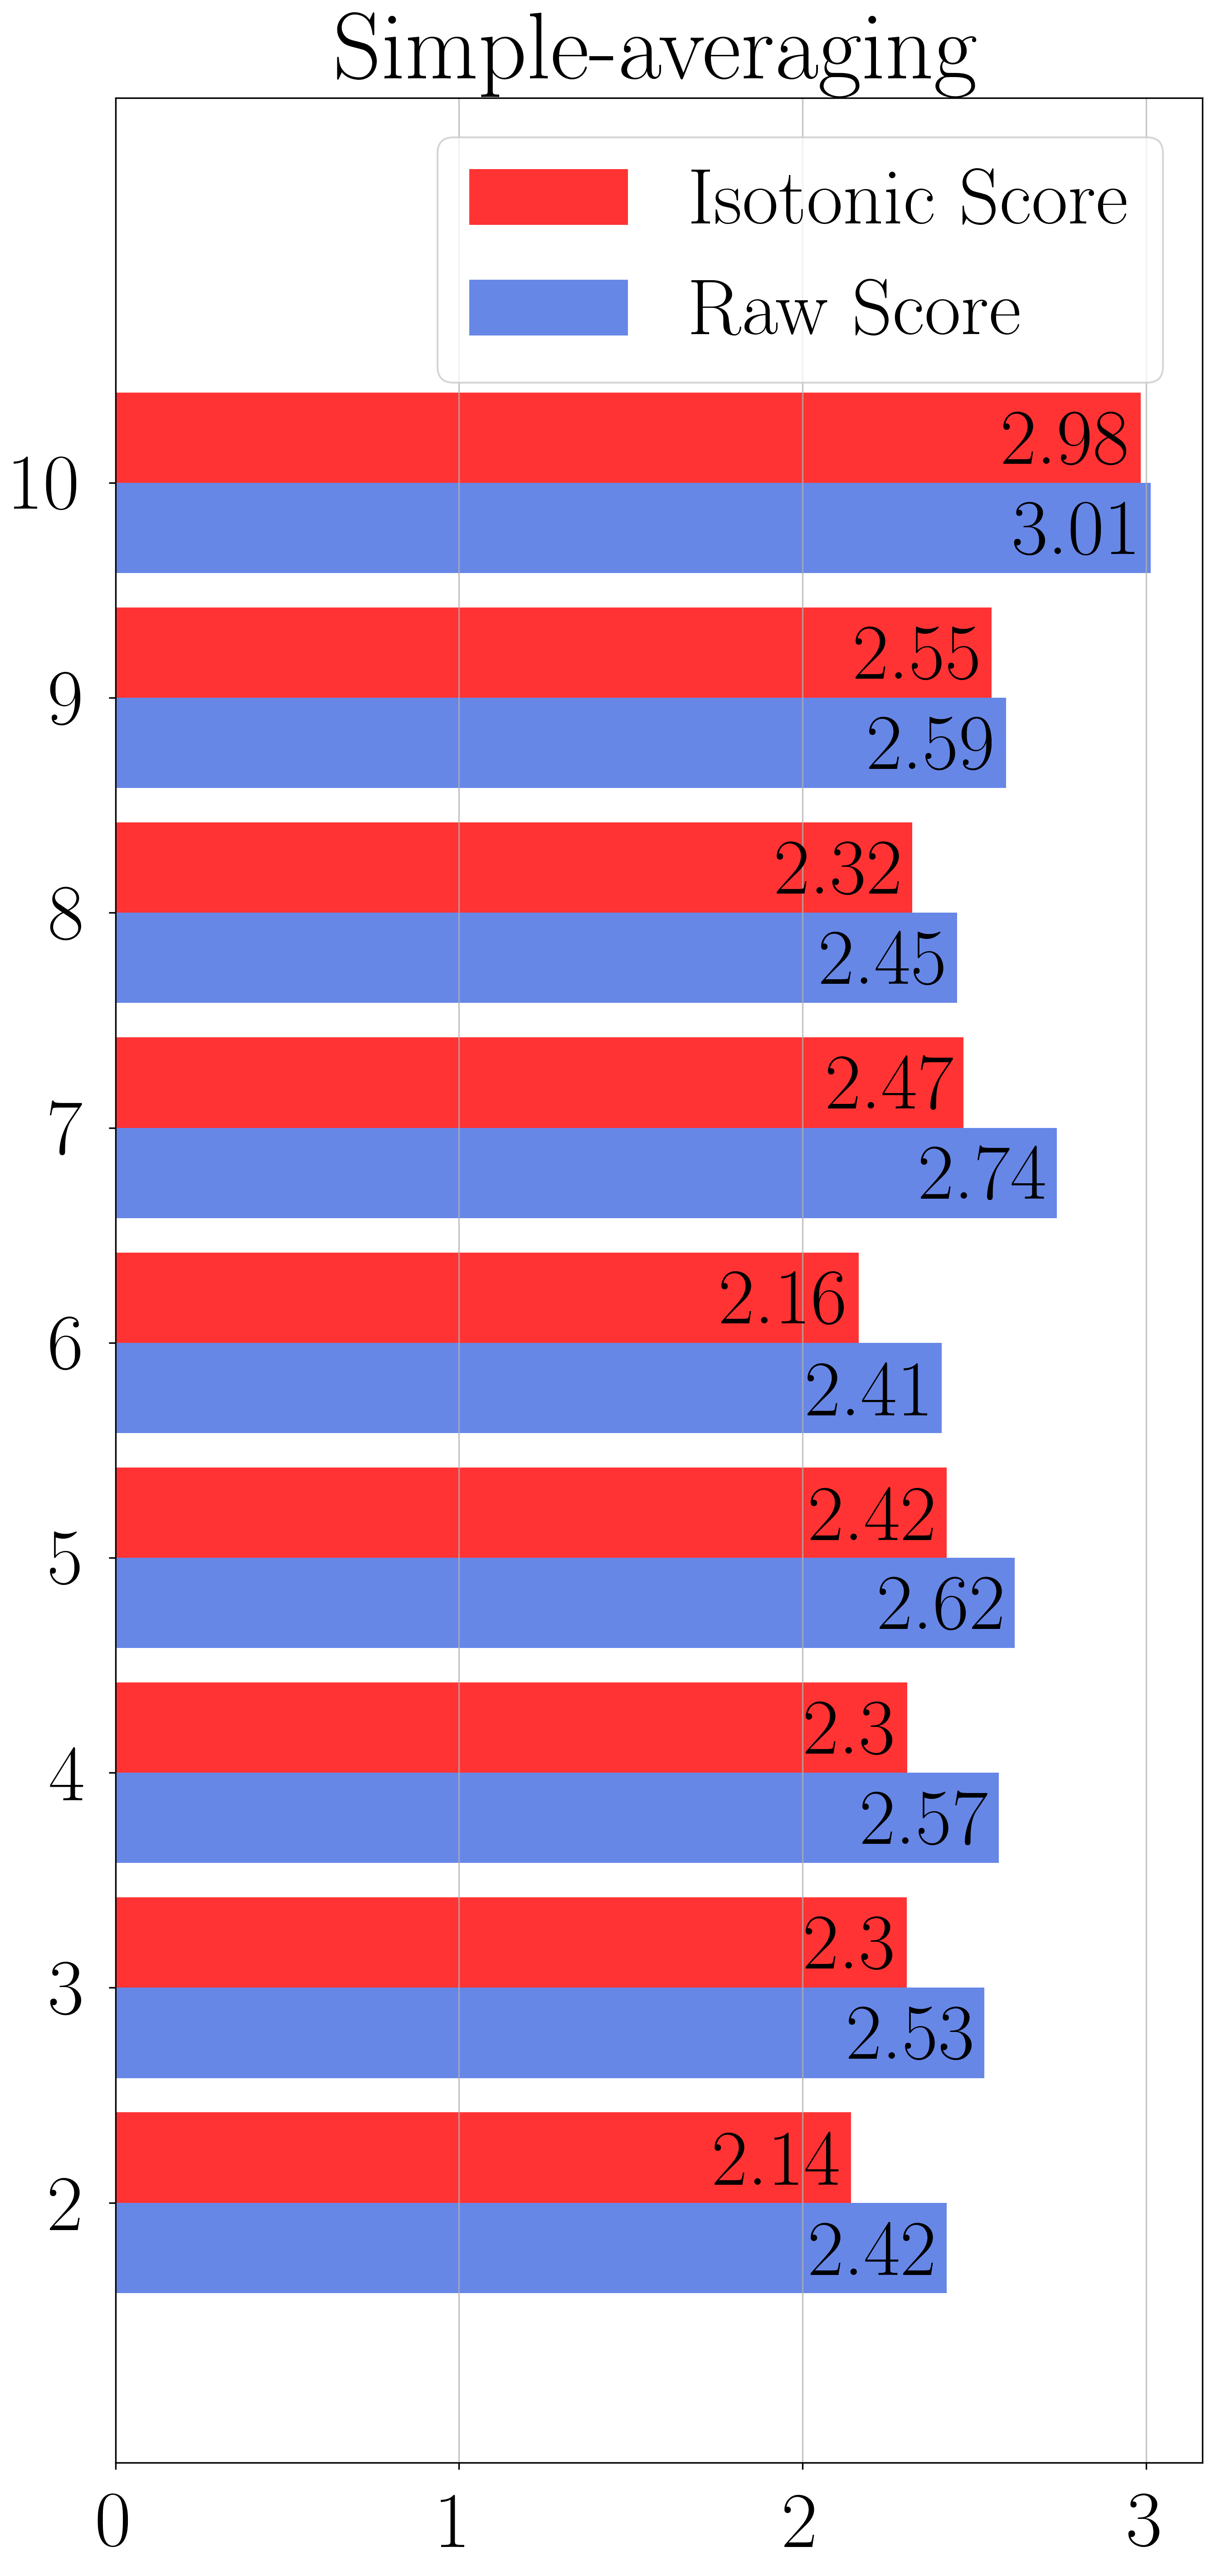

In [ ]:
# Generate some example data
coauthors = list(range(2, 11))

# Create a figure and axis
fig, ax = plt.subplots()

# Set the total bar width (for both sets)
total_bar_width = 0.84

# Calculate the bar positions for two sets of data
bar_positions_1 = np.arange(len(coauthors))
bar_positions_2 = bar_positions_1 + total_bar_width/2

# Set the individual bar width for each set
bar_width = total_bar_width / 2

# Create the horizontal bars for each set of data
bars_2 = ax.barh(bar_positions_2, new_mse_list, bar_width, alpha = 0.8, color = 'red', label='Isotonic Score    ')
bars_1 = ax.barh(bar_positions_1, old_mse_list, bar_width, alpha = 0.8, color = 'royalblue', label='Raw Score    ')



# Add labels to the bars
for bar in bars_1 + bars_2:
    width = round(bar.get_width(),2)
    if 0.90 > width > 0:
        ax.annotate(f'{width}', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')
    if width > 0.90:
        ax.annotate(f'{width}', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')

# Set labels, title, and legend
plt.grid(axis='x', alpha=0.75)
# ax.set_xlabel('(a) Mean Squared Error')
# ax.set_ylabel('Mean Squared Error')
ax.set_title('Simple-averaging')
ax.set_ylim(-1,10)
ax.set_yticks(bar_positions_1 + total_bar_width / 4)
ax.set_yticklabels(coauthors)
ax.legend(loc='upper right')
ax.tick_params(axis='x', pad=12)
ax.tick_params(axis='y', pad=12)

plt.savefig("Figures/revision_adhoc_iso_no_coauthor_vertical_L2.pdf", bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()

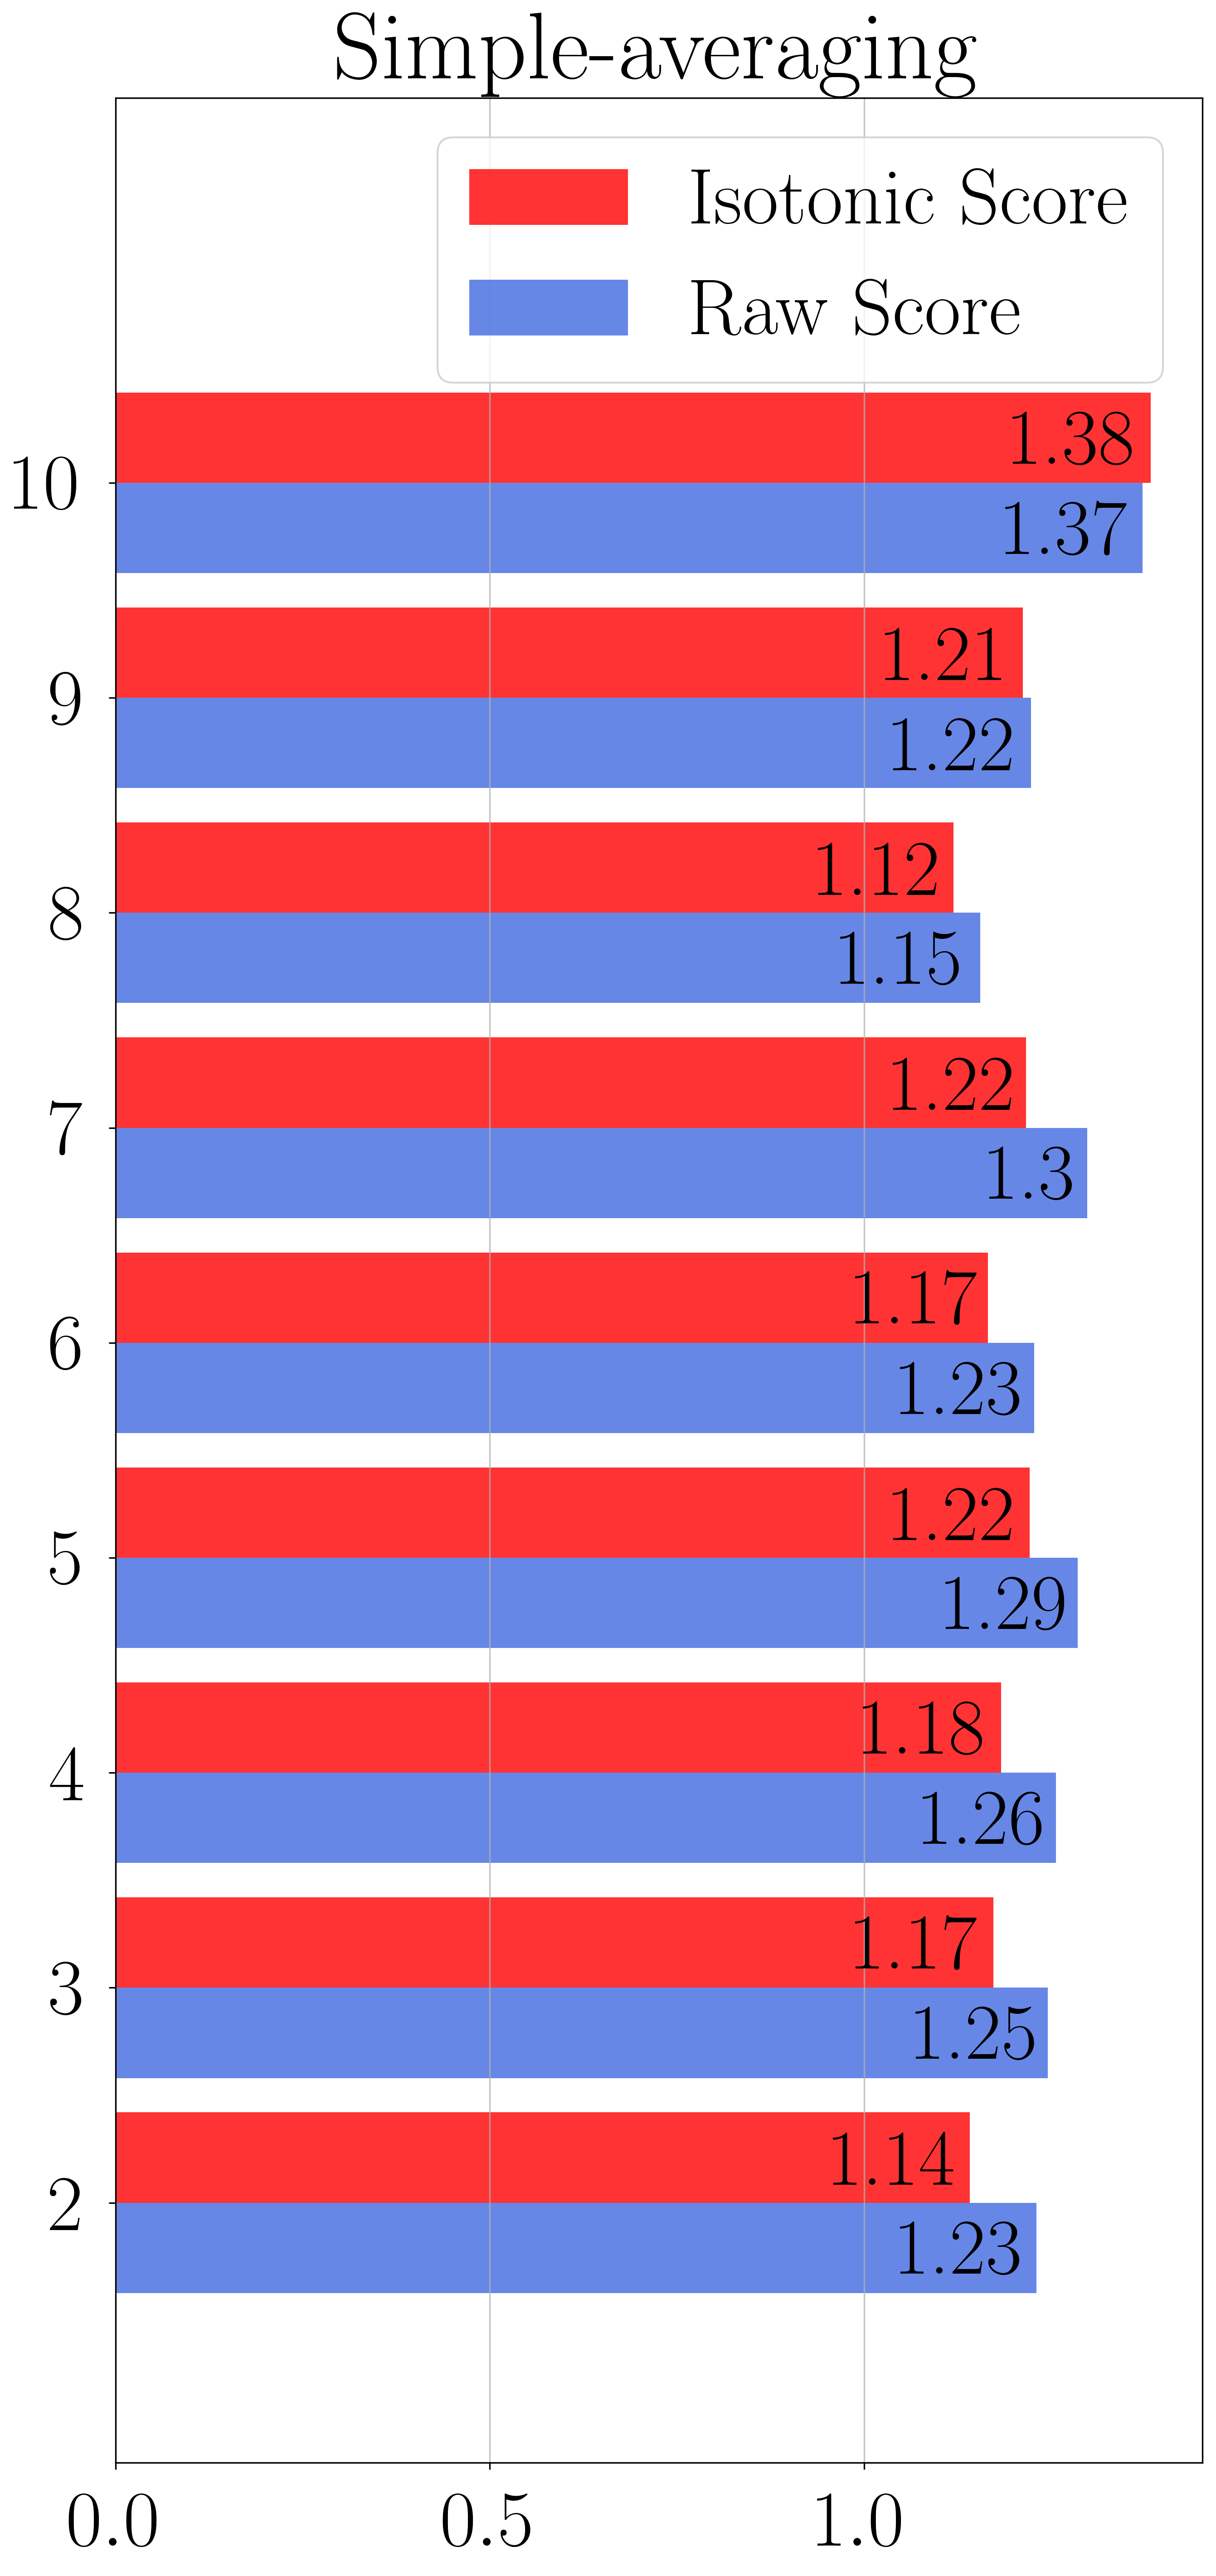

In [ ]:
# Generate some example data
coauthors = list(range(2, 11))

# Create a figure and axis
fig, ax = plt.subplots()

# Set the total bar width (for both sets)
total_bar_width = 0.84

# Calculate the bar positions for two sets of data
bar_positions_1 = np.arange(len(coauthors))
bar_positions_2 = bar_positions_1 + total_bar_width/2

# Set the individual bar width for each set
bar_width = total_bar_width / 2

# Create the horizontal bars for each set of data
bars_2 = ax.barh(bar_positions_2, new_mae_list, bar_width, alpha = 0.8, color = 'red', label='Isotonic Score    ')
bars_1 = ax.barh(bar_positions_1, old_mae_list, bar_width, alpha = 0.8, color = 'royalblue', label='Raw Score    ')



# Add labels to the bars
for bar in bars_1 + bars_2:
    width = round(bar.get_width(),2)
    if 0.90 > width > 0:
        ax.annotate(f'{width}', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')
    if width > 0.90:
        ax.annotate(f'{width}', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')

# Set labels, title, and legend
plt.grid(axis='x', alpha=0.75)
# ax.set_xlabel('(a) Mean Squared Error')
# ax.set_ylabel('Mean Squared Error')
ax.set_title('Simple-averaging')
ax.set_ylim(-1,10)
ax.set_yticks(bar_positions_1 + total_bar_width / 4)
ax.set_yticklabels(coauthors)
ax.legend(loc='upper right')
ax.tick_params(axis='x', pad=12)
ax.tick_params(axis='y', pad=12)

plt.savefig("Figures/revision_adhoc_iso_no_coauthor_vertical_L1.pdf", bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()



# **Greedy/Multi-owner Isotonic Scores, Proxy**

In [10]:
new_greedy_mse_list = []
new_multi_mse_list = []
old_mse_list = []
new_greedy_mae_list = []
new_multi_mae_list = []
old_mae_list = []

for j in range(2, 11):

    print('-'*20)
    print("number of coauthors:", j)
    print(len(split_dfs[j]['author_idx'].unique()))
    print(len(split_dfs[j]['submission_idx'].unique()))

    split_dfs[j] = split_dfs[j].drop_duplicates(['submission_idx', 'author_idx'])

    # Extract the unique authors from the DataFrame
    authors = split_dfs[j]['author_idx'].unique()
    submissions = split_dfs[j]['submission_idx'].unique()

    author_submission = {}
    for author in authors:
        submissionss = list( set(split_dfs[j][split_dfs[j]['author_idx'] == author]['submission_idx'].tolist()) )
        author_submission[author] = submissionss

    m_2 = len(author_submission)
    n_2 = len(submissions)

    authors = []
    for author in author_submission:
        submission_ranking = {}
        for i in range(len(author_submission[author])):
            submission_ranking[author_submission[author][i]] = split_dfs[j][(split_dfs[j]['submission_idx'] == author_submission[author][i]) & (split_dfs[j]['author_idx'] == author)]['rank'].tolist()
            submission_ranking[author_submission[author][i]] = submission_ranking[author_submission[author][i]][0]
        authors.append(submission_ranking)

    graph = {}
    for i, author in enumerate(authors):
        graph[i] = set( int(k) for k in author.keys())

    # Partition all the graph according to Multi-owner algorithm
    partition, author_parts = arbitrary(graph, m_2, n_2)
    author_parts = validate(partition, graph, n_2)

    calibrated_scores = np.zeros(n_2)
    for part, author_part in zip(partition, author_parts):
      if len(author_part) == 0:
        for i in part: calibrated_scores[i] = split_dfs[j][split_dfs[j]['submission_idx'] == i]['score'].tolist()[0]
        continue
      paper_part = list(part)



      # Organize each block by {author: [submission, rank, score]}.
      author_submission_rank_old = {}
      for author in author_part:
        author_submission_rank_old[author] = []
        for i in range(len(paper_part)):
            rank = split_dfs[j][(split_dfs[j]['submission_idx'] == paper_part[i]) & (split_dfs[j]['author_idx'] == author)]['rank'].tolist()[0]
            ratings = split_dfs[j][(split_dfs[j]['submission_idx'] == paper_part[i]) & (split_dfs[j]['author_idx'] == author)]['score'].tolist()[0]
            author_submission_rank_old[author].append((paper_part[i], rank, ratings))



      # Sort submissions by rank; in case of ties, sort by score.
      def sort_submissions(author_submission_rank_old):
        for author in author_submission_rank_old:
          author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
        return author_submission_rank_old
      author_submission_rank_old = sort_submissions(author_submission_rank_old)



      # Compute isotonic scores for each author in the block.
      author_submission_rank_multi_iso = {}
      for author in author_submission_rank_old:
          ir_rank = []
          for i in range(len(author_submission_rank_old[author])):
              r1 = author_submission_rank_old[author][i][2]
              ir_rank.append(r1)
          ir_rank = np.array(ir_rank)
          ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)

          author_submission_rank_multi_iso[author] = []
          for i in range(len(author_submission_rank_old[author])):
              author_submission_rank_multi_iso[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))



      # For multi-author submissions in a block, average the scores to get the isotonic score.
      submission_multi_iso_rating = {}
      for submission in paper_part:
          submission_multi_iso_rating[submission] = []

      for author in author_submission_rank_multi_iso:
          for i in range(len(author_submission_rank_multi_iso[author])):
              submission_multi_iso_rating[author_submission_rank_multi_iso[author][i][0]].append(author_submission_rank_multi_iso[author][i][2])

      for submission in submission_multi_iso_rating:
          submission_multi_iso_rating[submission] = [float(rating) for rating in submission_multi_iso_rating[submission]]
          avg_rating = sum(submission_multi_iso_rating[submission])/len(submission_multi_iso_rating[submission])
          submission_multi_iso_rating[submission] = avg_rating

      for i in paper_part:
        calibrated_scores[i] = submission_multi_iso_rating[i]



    # Multi-owner Isotonic Score
    multi_iso_rating = []
    for i in range(n_2):
      multi_iso_rating.append(calibrated_scores[i])

    # Partition all the graph according to greedy algorithm
    partition, author_parts = greedy(graph, m_2, n_2)
    author_parts = validate(partition, graph, n_2)

    calibrated_scores = np.zeros(n_2)
    for part, author_part in zip(partition, author_parts):
      if len(author_part) == 0:
        for i in part: calibrated_scores[i] = split_dfs[j][split_dfs[j]['submission_idx'] == i]['score'].tolist()[0]
        continue
      paper_part = list(part)



      # Organize each block by {author: [submission, rank, score]}.
      author_submission_rank_old = {}
      for author in author_part:
        author_submission_rank_old[author] = []
        for i in range(len(paper_part)):
            rank = split_dfs[j][(split_dfs[j]['submission_idx'] == paper_part[i]) & (split_dfs[j]['author_idx'] == author)]['rank'].tolist()[0]
            ratings = split_dfs[j][(split_dfs[j]['submission_idx'] == paper_part[i]) & (split_dfs[j]['author_idx'] == author)]['score'].tolist()[0]
            author_submission_rank_old[author].append((paper_part[i], rank, ratings))



      # Sort submissions by rank; in case of ties, sort by score.
      def sort_submissions(author_submission_rank_old):
        for author in author_submission_rank_old:
          author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
        return author_submission_rank_old
      author_submission_rank_old = sort_submissions(author_submission_rank_old)



      # Compute isotonic scores for each author in the block.
      author_submission_rank_greedy_iso = {}
      for author in author_submission_rank_old:
          ir_rank = []
          for i in range(len(author_submission_rank_old[author])):
              r1 = author_submission_rank_old[author][i][2]
              ir_rank.append(r1)
          ir_rank = np.array(ir_rank)
          ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)

          author_submission_rank_greedy_iso[author] = []
          for i in range(len(author_submission_rank_old[author])):
              author_submission_rank_greedy_iso[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))



      # For multi-author submissions in a block, average the scores to get the isotonic score.
      submission_greedy_iso_rating = {}
      for submission in paper_part:
          submission_greedy_iso_rating[submission] = []

      for author in author_submission_rank_greedy_iso:
          for i in range(len(author_submission_rank_greedy_iso[author])):
              submission_greedy_iso_rating[author_submission_rank_greedy_iso[author][i][0]].append(author_submission_rank_greedy_iso[author][i][2])

      for submission in submission_greedy_iso_rating:
          submission_greedy_iso_rating[submission] = [float(rating) for rating in submission_greedy_iso_rating[submission]]
          avg_rating = sum(submission_greedy_iso_rating[submission])/len(submission_greedy_iso_rating[submission])
          submission_greedy_iso_rating[submission] = avg_rating

      for i in paper_part:
        calibrated_scores[i] = submission_greedy_iso_rating[i]



    # Greedy Isotonic Score
    greedy_iso_rating = []
    for i in range(n_2):
      greedy_iso_rating.append(calibrated_scores[i])

    # proxy
    submission_true_rating = {}
    for submission in range(n_2):
        submission_true_rating[submission] = split_dfs[j][split_dfs[j]['submission_idx'] == submission]['proxy'].tolist()
        submission_true_rating[submission] = submission_true_rating[submission][0]

    True_score_multi_iso = []
    for i in range(n_2):
        True_score_multi_iso.append(submission_true_rating[i])



    # score
    old_rating = {}
    for submission in range(n_2):
        old_rating[submission] = split_dfs[j][split_dfs[j]['submission_idx'] == submission]['score'].tolist()
        old_rating[submission] = old_rating[submission][0]

    old_score_multi_iso = []
    for i in range(n_2):
        old_score_multi_iso.append(old_rating[i])



    # print the MSE
    print('Greedy Isotonic Mechanism', mean_squared_error(greedy_iso_rating, True_score_multi_iso))
    print('Multiowner Isotonic Mechanism', mean_squared_error(multi_iso_rating, True_score_multi_iso))
    print('Review Rating', mean_squared_error(old_score_multi_iso, True_score_multi_iso))


    new_greedy_mse_list.append(mean_squared_error(greedy_iso_rating, True_score_multi_iso))
    new_multi_mse_list.append(mean_squared_error(multi_iso_rating, True_score_multi_iso))
    old_mse_list.append(mean_squared_error(old_score_multi_iso, True_score_multi_iso))

    new_greedy_mae_list.append(mean_absolute_error(greedy_iso_rating, True_score_multi_iso))
    new_multi_mae_list.append(mean_absolute_error(multi_iso_rating, True_score_multi_iso))
    old_mae_list.append(mean_absolute_error(old_score_multi_iso, True_score_multi_iso))


--------------------
number of coauthors: 2
209
259
Greedy Isotonic Mechanism 2.1326587301587296
Multiowner Isotonic Mechanism 2.140380737880738
Review Rating 2.4191023166023164
--------------------
number of coauthors: 3
431
464
Greedy Isotonic Mechanism 2.3230962643678157
Multiowner Isotonic Mechanism 2.3216594827586206
Review Rating 2.528436302681992
--------------------
number of coauthors: 4
567
539
Greedy Isotonic Mechanism 2.301165223665224
Multiowner Isotonic Mechanism 2.3040203050917336
Review Rating 2.571052875695733
--------------------
number of coauthors: 5
542
475
Greedy Isotonic Mechanism 2.4003362573099416
Multiowner Isotonic Mechanism 2.4047105263157893
Review Rating 2.6175877192982457
--------------------
number of coauthors: 6
425
353
Greedy Isotonic Mechanism 2.2235009442870632
Multiowner Isotonic Mechanism 2.1955264400377716
Review Rating 2.405394239848914
--------------------
number of coauthors: 7
265
190
Greedy Isotonic Mechanism 2.443017543859649
Multiowner Iso

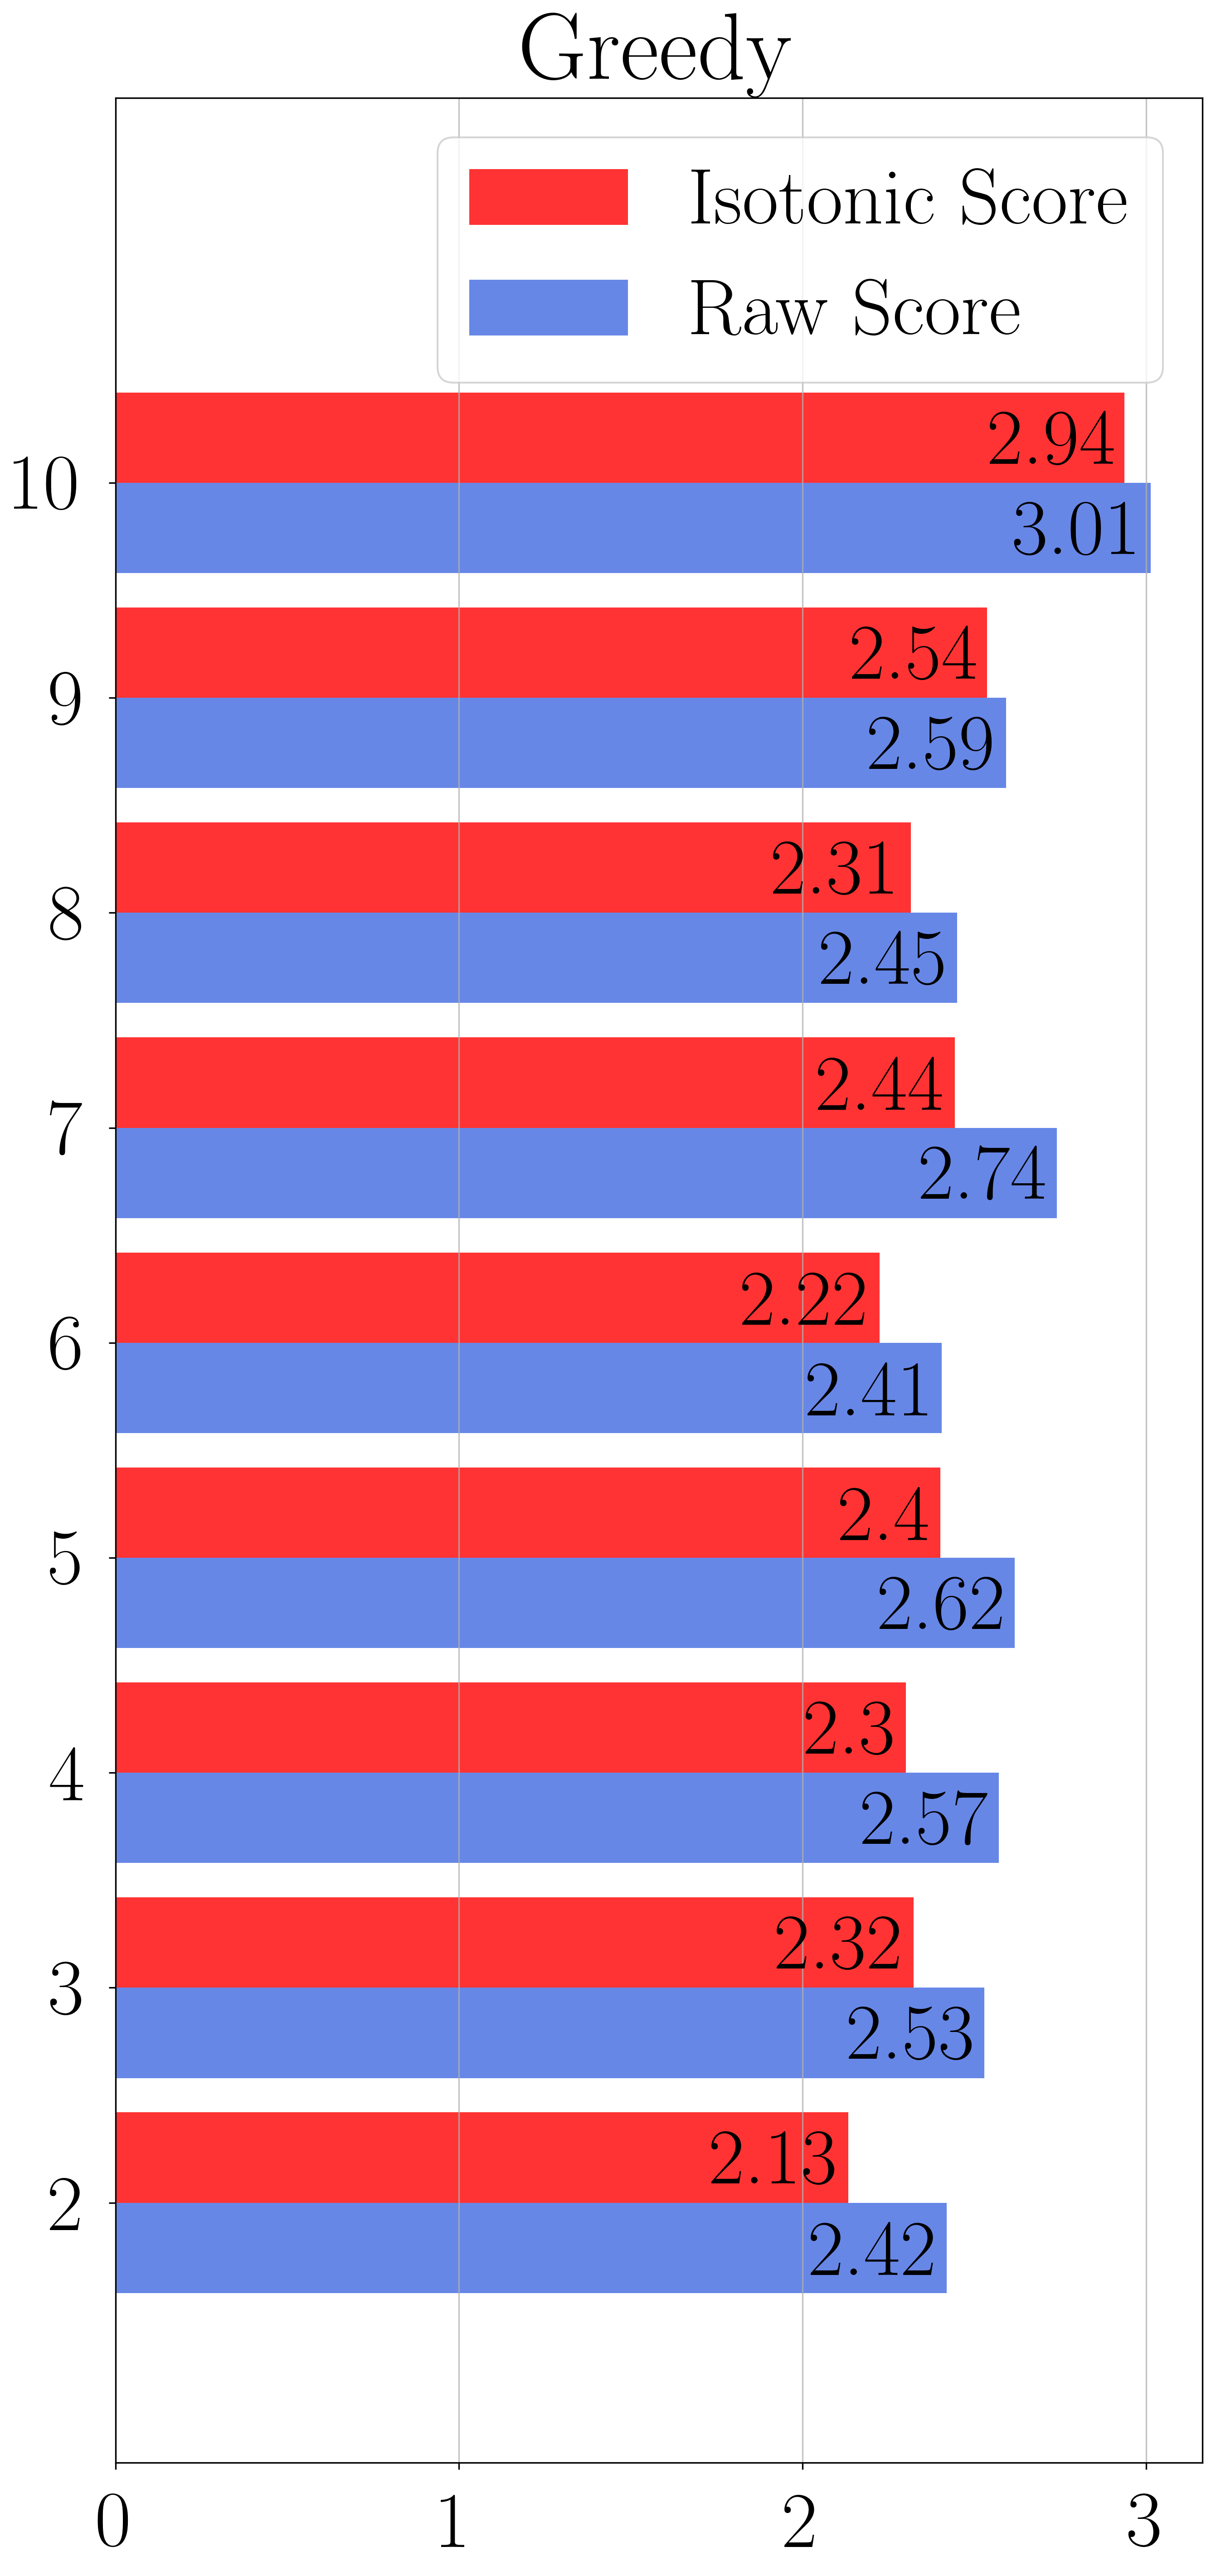

In [ ]:
# Generate some example data
coauthors = list(range(2, 11))

# Create a figure and axis
fig, ax = plt.subplots()

# Set the total bar width (for both sets)
total_bar_width = 0.84

# Calculate the bar positions for two sets of data
bar_positions_1 = np.arange(len(coauthors))
bar_positions_2 = bar_positions_1 + total_bar_width/2

# Set the individual bar width for each set
bar_width = total_bar_width / 2

# Create the horizontal bars for each set of data
bars_2 = ax.barh(bar_positions_2, new_greedy_mse_list, bar_width, alpha = 0.8, color = 'red', label='Isotonic Score    ')
bars_1 = ax.barh(bar_positions_1, old_mse_list, bar_width, alpha = 0.8, color = 'royalblue', label='Raw Score    ')



# Add labels to the bars
for bar in bars_1 + bars_2:
    width = round(bar.get_width(),2)
    if 0.90 > width > 0:
        ax.annotate(f'{width}', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')
    if width > 0.90:
        ax.annotate(f'{width}', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')

# Set labels, title, and legend
plt.grid(axis='x', alpha=0.75)
# ax.set_xlabel('(a) Mean Squared Error')
# ax.set_ylabel('Mean Squared Error')
ax.set_title('Greedy')
ax.set_ylim(-1,10)
ax.set_yticks(bar_positions_1 + total_bar_width / 4)
ax.set_yticklabels(coauthors)
ax.legend(loc='upper right')
ax.tick_params(axis='x', pad=12)
ax.tick_params(axis='y', pad=12)

plt.savefig("Figures/revision_greedy_iso_no_coauthor_vertical_L2.pdf", bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()

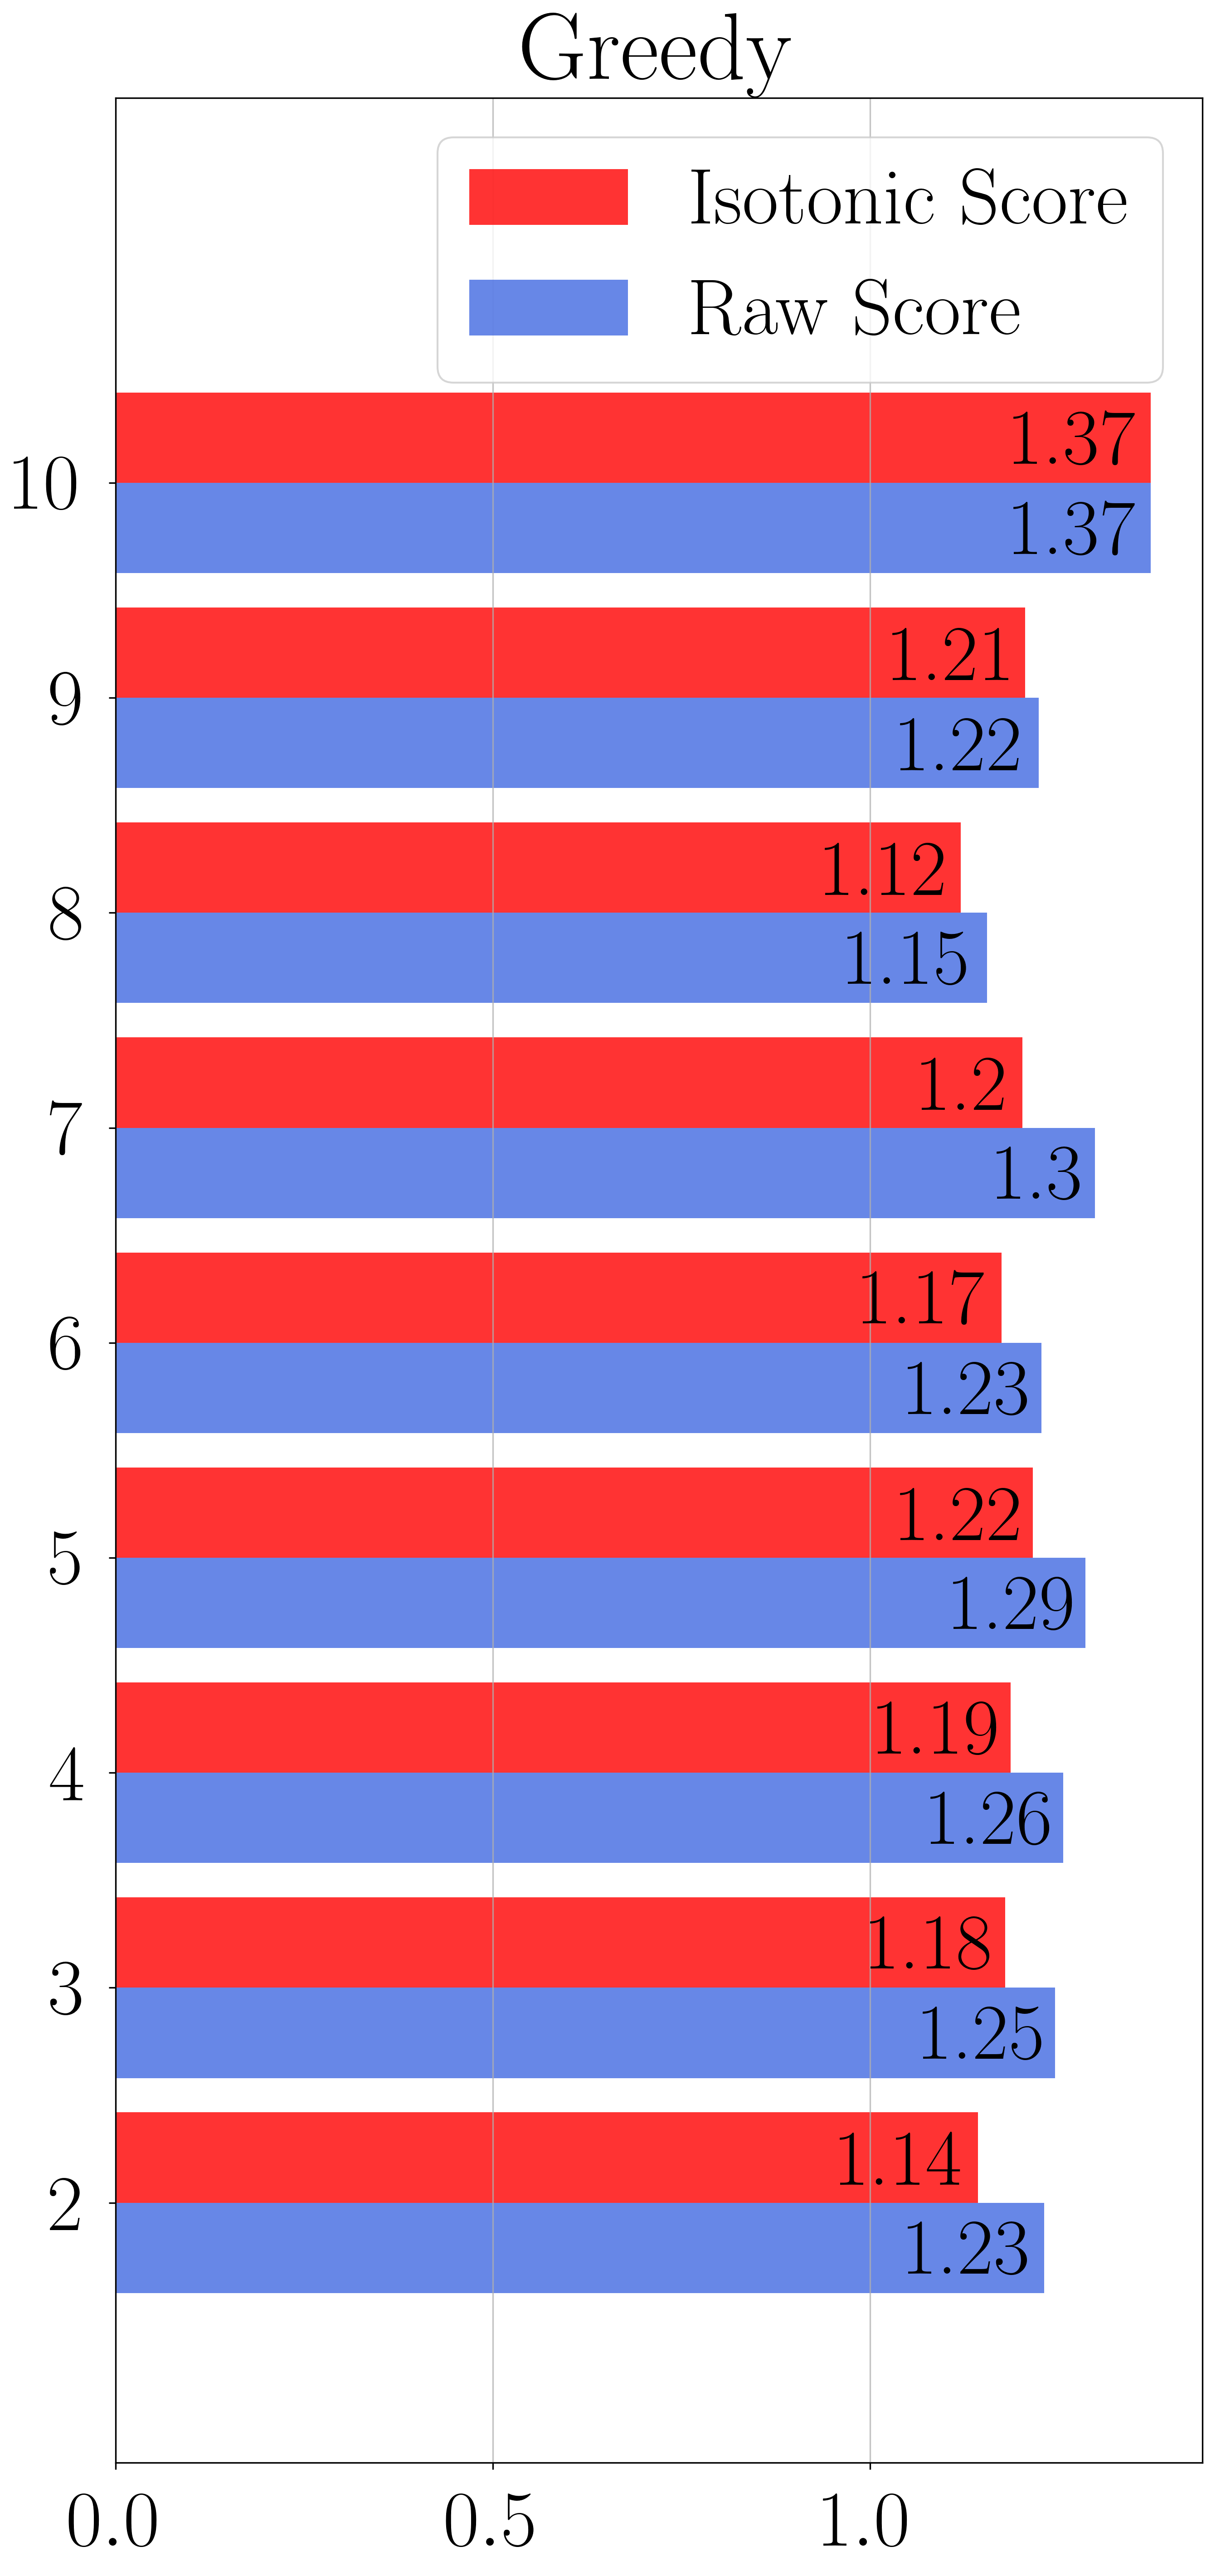

In [ ]:
# Generate some example data
coauthors = list(range(2, 11))

# Create a figure and axis
fig, ax = plt.subplots()

# Set the total bar width (for both sets)
total_bar_width = 0.84

# Calculate the bar positions for two sets of data
bar_positions_1 = np.arange(len(coauthors))
bar_positions_2 = bar_positions_1 + total_bar_width/2

# Set the individual bar width for each set
bar_width = total_bar_width / 2

# Create the horizontal bars for each set of data
bars_2 = ax.barh(bar_positions_2, new_greedy_mae_list, bar_width, alpha = 0.8, color = 'red', label='Isotonic Score    ')
bars_1 = ax.barh(bar_positions_1, old_mae_list, bar_width, alpha = 0.8, color = 'royalblue', label='Raw Score    ')



# Add labels to the bars
for bar in bars_1 + bars_2:
    width = round(bar.get_width(),2)
    if 0.90 > width > 0:
        ax.annotate(f'{width}', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')
    if width > 0.90:
        ax.annotate(f'{width}', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')

# Set labels, title, and legend
plt.grid(axis='x', alpha=0.75)
# ax.set_xlabel('(a) Mean Squared Error')
# ax.set_ylabel('Mean Squared Error')
ax.set_title('Greedy')
ax.set_ylim(-1,10)
ax.set_yticks(bar_positions_1 + total_bar_width / 4)
ax.set_yticklabels(coauthors)
ax.legend(loc='upper right')
ax.tick_params(axis='x', pad=12)
ax.tick_params(axis='y', pad=12)

plt.savefig("Figures/revision_greedy_iso_no_coauthor_vertical_L1.pdf", bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()

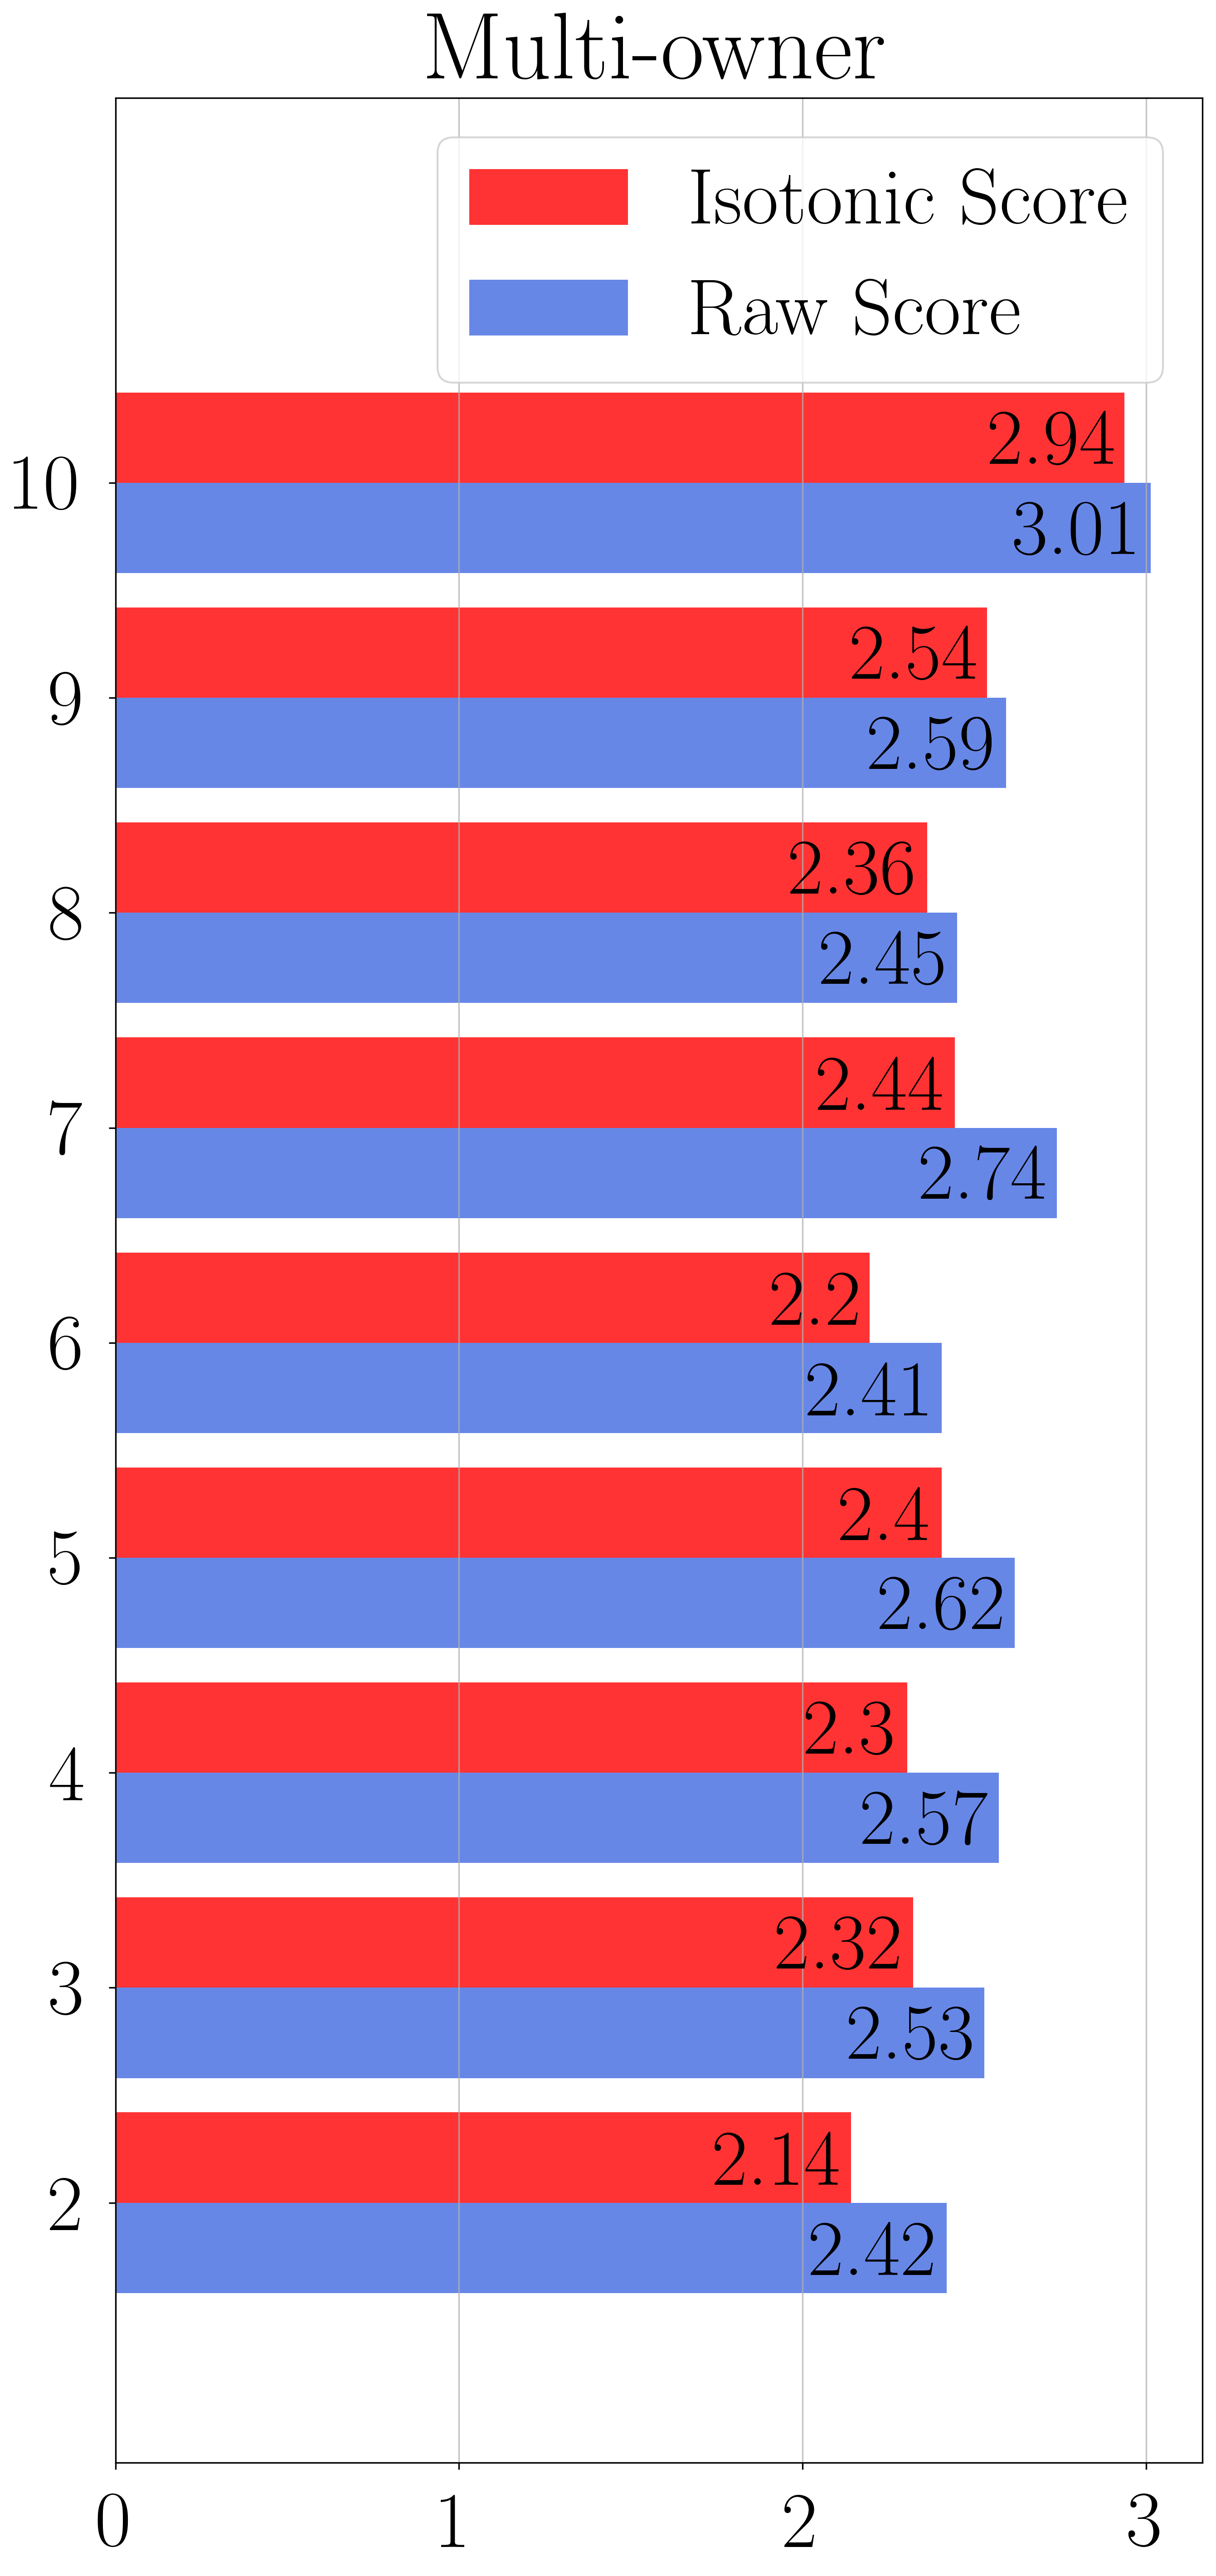

In [ ]:
# Generate some example data
coauthors = list(range(2, 11))

# Create a figure and axis
fig, ax = plt.subplots()

# Set the total bar width (for both sets)
total_bar_width = 0.84

# Calculate the bar positions for two sets of data
bar_positions_1 = np.arange(len(coauthors))
bar_positions_2 = bar_positions_1 + total_bar_width/2

# Set the individual bar width for each set
bar_width = total_bar_width / 2

# Create the horizontal bars for each set of data
bars_2 = ax.barh(bar_positions_2, new_multi_mse_list, bar_width, alpha = 0.8, color = 'red', label='Isotonic Score    ')
bars_1 = ax.barh(bar_positions_1, old_mse_list, bar_width, alpha = 0.8, color = 'royalblue', label='Raw Score    ')



# Add labels to the bars
for bar in bars_1 + bars_2:
    width = round(bar.get_width(),2)
    if 0.90 > width > 0:
        ax.annotate(f'{width}', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')
    if width > 0.90:
        ax.annotate(f'{width}', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')

# Set labels, title, and legend
plt.grid(axis='x', alpha=0.75)
# ax.set_xlabel('(a) Mean Squared Error')
# ax.set_ylabel('Mean Squared Error')
ax.set_title('Multi-owner')
ax.set_ylim(-1,10)
ax.set_yticks(bar_positions_1 + total_bar_width / 4)
ax.set_yticklabels(coauthors)
ax.legend(loc='upper right')
ax.tick_params(axis='x', pad=12)
ax.tick_params(axis='y', pad=12)

plt.savefig("Figures/revision_multi_iso_no_coauthor_vertical_L2.pdf", bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()

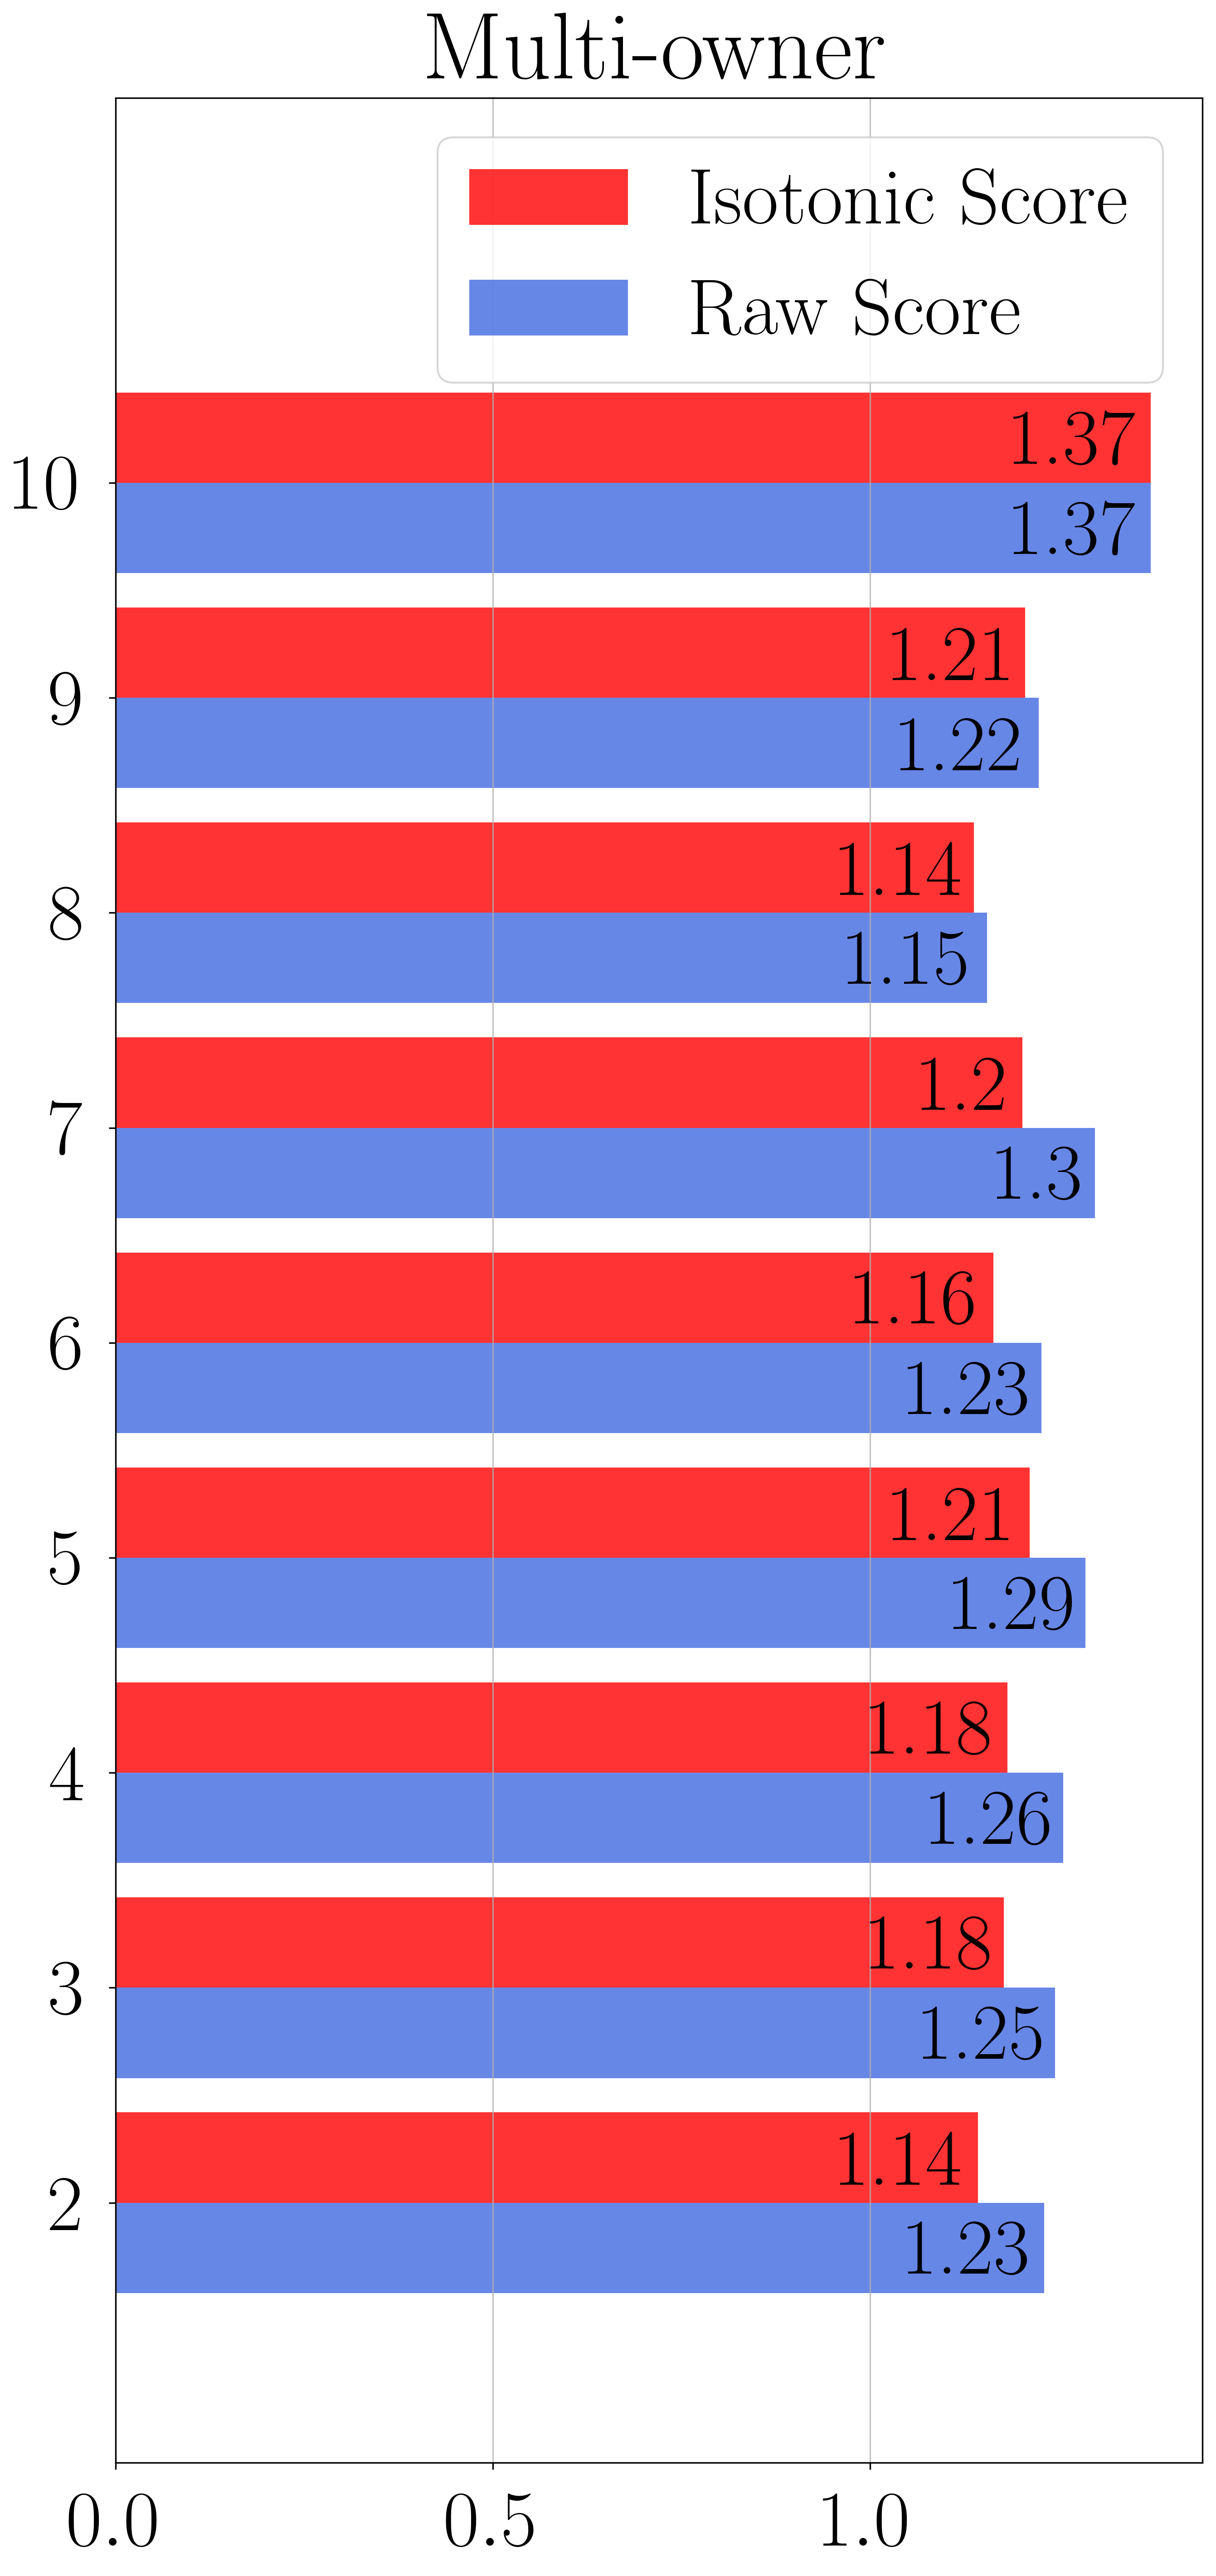

In [ ]:
# Generate some example data
coauthors = list(range(2, 11))

# Create a figure and axis
fig, ax = plt.subplots()

# Set the total bar width (for both sets)
total_bar_width = 0.84

# Calculate the bar positions for two sets of data
bar_positions_1 = np.arange(len(coauthors))
bar_positions_2 = bar_positions_1 + total_bar_width/2

# Set the individual bar width for each set
bar_width = total_bar_width / 2

# Create the horizontal bars for each set of data
bars_2 = ax.barh(bar_positions_2, new_multi_mae_list, bar_width, alpha = 0.8, color = 'red', label='Isotonic Score    ')
bars_1 = ax.barh(bar_positions_1, old_mae_list, bar_width, alpha = 0.8, color = 'royalblue', label='Raw Score    ')



# Add labels to the bars
for bar in bars_1 + bars_2:
    width = round(bar.get_width(),2)
    if 0.90 > width > 0:
        ax.annotate(f'{width}', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')
    if width > 0.90:
        ax.annotate(f'{width}', xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(-4, -4),  # Adjust this value to move the text left or right
                    textcoords='offset points',
                    ha='right', va='center')

# Set labels, title, and legend
plt.grid(axis='x', alpha=0.75)
# ax.set_xlabel('(a) Mean Squared Error')
# ax.set_ylabel('Mean Squared Error')
ax.set_title('Multi-owner')
ax.set_ylim(-1,10)
ax.set_yticks(bar_positions_1 + total_bar_width / 4)
ax.set_yticklabels(coauthors)
ax.legend(loc='upper right')
ax.tick_params(axis='x', pad=12)
ax.tick_params(axis='y', pad=12)

plt.savefig("Figures/revision_multi_iso_no_coauthor_vertical_L1.pdf", bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()